#Libraries

In [0]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

#Data

Since the Government fails to provide a complete and open dataset for disease status in the country, several young doctors in Myanmar volunteered on their own to monitor announcements. Current data applied is collected by Dr. Nyein Chan Ko Ko.

In [0]:
data = "https://raw.githubusercontent.com/finerbrighterlighter/myanmar_covid19/master/announced_cases.csv"
columns = ["Date","Announced"]

In [24]:
confirmed_df = pd.read_csv(data,names = columns) 
confirmed_df["Date"] = pd.to_datetime(confirmed_df["Date"])
confirmed_df["Case"] = confirmed_df["Announced"].cumsum()
confirmed_df["ndays"] = np.arange(len(confirmed_df))

# Natural Log of Real Cases
confirmed_df["logCase"] = np.log(confirmed_df.Case).astype(float)

print(confirmed_df)

        Date  Announced  Case  ndays   logCase
0 2021-03-21          1     1      0  0.000000
1 2021-03-22          0     1      1  0.000000
2 2021-03-23          2     3      2  1.098612
3 2021-03-24          0     3      3  1.098612
4 2021-03-25          2     5      4  1.609438
5 2021-03-26          3     8      5  2.079442
6 2021-03-27          0     8      6  2.079442
7 2021-03-28          0     8      7  2.079442
8 2021-03-29          2    10      8  2.302585
9 2021-03-30          4    14      9  2.639057


Natural log makes it better in terms of visualization and long term comparison, make the data look more linear. That is why I will be plotting both real and natural log line graphs.

# Model of choice

True exponential does not exist, but exponential growth is assumed until the inflection point has arrived. Linear Regression is applied.

## Logistic Regression
### Ordinary Least Squared Regression

In [25]:
X = confirmed_df.ndays
X = sm.add_constant(X)
y = confirmed_df.logCase
model = sm.OLS(y, X)
result = model.fit()
result.summary()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logCase   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     75.36
Date:                Mon, 30 Mar 2020   Prob (F-statistic):           2.41e-05
Time:                        13:44:13   Log-Likelihood:                -1.2175
No. Observations:                  10   AIC:                             6.435
Df Residuals:                       8   BIC:                             7.040
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1845      0.180      1.027      0.334      -0.230       0.599
ndays          0.2920      0.034      8.681      0.000       0.214       0.370
==============================================================================
Omnibus:                        0.401   Durbin-Watson:                   1.443
Prob(Omnibus):                  0.818   Jarque-Bera (JB):                0.461
Skew:                           0.022   Prob(JB):                        0.794
Kurtosis:                       1.949   Cond. No.                         10.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Exponential Formaula<br> y = ab<sup>x</sup> <br>
a = Initial Value<br>
b = Rate of Change<br>
x = The feature ( Here it is time )<br>

b = (1+r) = Growth Rate <- Before Inflection <br>
b = (1-r) = Decay Rate <- After Inflection <br>

In the summary, "constant stands" for initial "a".<br>
"ndays" is the coefficient of "time", which means the value increasing y as x is increased by 1. In our case, the number of cases to increase as the next day comes.

In [0]:
def linear_predictions(t):
    return np.exp(result.params["const"]) * np.exp(result.params["ndays"]) ** t

As we fitted our model with natural log values, we should change them back to real numbers to predict.

# Next Week Prediction

In [27]:
ndays = len(confirmed_df)+3
nextweek_df = pd.DataFrame(columns=["ndays","Date"])
nextweek_df["ndays"] = np.arange(ndays)
nextweek_df.loc[0,"Date"]=confirmed_df.loc[0,"Date"]
for i in range(1,len(nextweek_df)):
    nextweek_df.loc[i,"Date"] = nextweek_df.loc[i-1,"Date"] + pd.Timedelta(days=1)
    i=i+1
nextweek_df["Predictions"] = nextweek_df.ndays.apply(linear_predictions)

# Natural Log of Predicted Cases
nextweek_df["logPredictions"] = np.log(nextweek_df.Predictions).astype(float)

print(nextweek_df)

    ndays                 Date  Predictions  logPredictions
0       0  2021-03-21 00:00:00     1.202608        0.184493
1       1  2021-03-22 00:00:00     1.610477        0.476530
2       2  2021-03-23 00:00:00     2.156676        0.768568
3       3  2021-03-24 00:00:00     2.888121        1.060606
4       4  2021-03-25 00:00:00     3.867638        1.352644
5       5  2021-03-26 00:00:00     5.179362        1.644682
6       6  2021-03-27 00:00:00     6.935962        1.936720
7       7  2021-03-28 00:00:00     9.288319        2.228758
8       8  2021-03-29 00:00:00    12.438488        2.520796
9       9  2021-03-30 00:00:00    16.657047        2.812833
10     10  2021-03-31 00:00:00    22.306347        3.104871
11     11  2021-04-01 00:00:00    29.871628        3.396909
12     12  2021-04-02 00:00:00    40.002702        3.688947


Although I stated next week, here I added only "3". Since our data and history is very short right now, it is not sufficient to predict far without sacraficing. This currently here is a proof of concept. We shall increase the data and after that, we should pursure further analysis.

# Real Number Plot

In [0]:
a = str(confirmed_df["Date"][confirmed_df.index[-1]])+"_real.svg"
b = str(confirmed_df["Date"][confirmed_df.index[-1]])+"_log.svg"

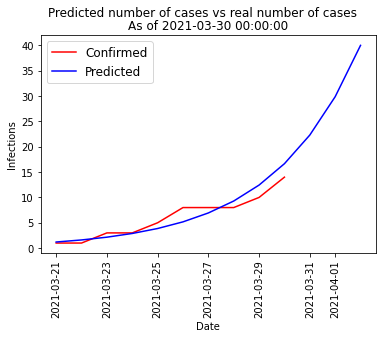

In [29]:
confirmed_x = pd.date_range(start=confirmed_df["Date"][confirmed_df.index[0]], end=confirmed_df["Date"][confirmed_df.index[-1]])
confirmed_y = confirmed_df["Case"].tolist()
confirmed_plot = pd.Series(data=confirmed_y, index=confirmed_x)

nextweek_x = pd.date_range(start=nextweek_df["Date"][nextweek_df.index[0]], end=nextweek_df["Date"][nextweek_df.index[-1]])
nextweek_y = nextweek_df["Predictions"].tolist()
nextweek_plot = pd.Series(data=nextweek_y, index=nextweek_x)

fig, ax = plt.subplots()
ax.plot(confirmed_plot, label="Confirmed", color="red")
ax.plot(nextweek_plot, label="Predicted", color ="blue")
legend = ax.legend(loc="upper left", fontsize="large")
plt.xlabel("Date")
plt.ylabel("Infections")
plt.suptitle("Predicted number of cases vs real number of cases")
plt.title("As of "+str(confirmed_df["Date"][confirmed_df.index[-1]]))
plt.xticks(rotation=90)
plt.savefig(a)
plt.show()
files.download(a)

# Natural Log Plot

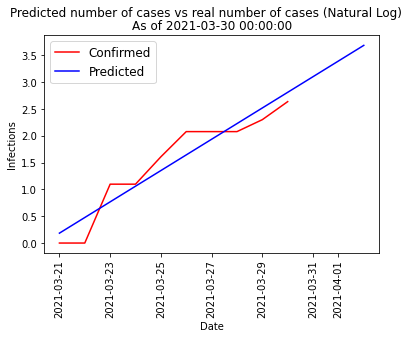

In [30]:
confirmed_logy = confirmed_df["logCase"].tolist()
confirmed_logplot = pd.Series(data=confirmed_logy, index=confirmed_x)

nextweek_logy = nextweek_df["logPredictions"].tolist()
nextweek_logplot = pd.Series(data=nextweek_logy, index=nextweek_x)

fig, ax = plt.subplots()
ax.plot(confirmed_logplot, label="Confirmed", color="red")
ax.plot(nextweek_logplot, label="Predicted", color ="blue")
legend = ax.legend(loc="upper left", fontsize="large")
plt.xlabel("Date")
plt.ylabel("Infections")
plt.suptitle("Predicted number of cases vs real number of cases (Natural Log)")
plt.title("As of "+str(confirmed_df["Date"][confirmed_df.index[-1]]))
plt.xticks(rotation=90)
plt.savefig(b)
plt.show()
files.download(b)